In [1]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import diffprivlib.models as dpm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") #warnings.filterwarnings("default")

# Load data

In [2]:
trump_data = pd.read_csv('../data/2016-cces-trump.csv')

# Visualize data


In [3]:
trump_data

,uid,stateabb,inputstate,race,angryracism,whiteadv,fearraces,racerare,acograc,aemprac,...,se_lrelig,z_acograc,z_aemprac,z_lcograc,z_lemprac,z_pid7na,z_lrelig,z_ideo,z_famincr,z_age
0,1,NH,33,1,2.0,3.0,1.0,3.0,3.0,1.5,...,0.246291,0.230760,-0.271252,0.295012,-0.146684,0.338328,-0.102495,-0.001742,NaN,-0.026144
1,2,LA,22,1,1.0,4.0,1.0,1.0,2.5,1.0,...,NaN,0.010444,-0.592603,-0.115771,-0.654787,0.103767,NaN,-0.001742,-0.044765,-0.768742
2,3,MO,29,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.278047,NaN,NaN,NaN,NaN,-0.599915,0.306842,0.920136,-0.354468,0.122376
3,4,AL,1,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.234668,NaN,NaN,NaN,NaN,0.103767,0.037493,0.459197,-0.819021,-0.590518
4,5,CO,8,1,2.0,1.0,1.0,1.0,1.0,1.5,...,0.321913,-0.650504,-0.271252,-0.746858,-0.146684,-0.365354,-0.604388,-0.462680,0.110086,-0.412295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64595,64596,NY,36,2,NaN,NaN,NaN,NaN,NaN,NaN,...,0.575410,NaN,NaN,NaN,NaN,-0.365354,0.908217,0.459197,-0.199617,-0.649926
64596,64597,CO,8,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.237046,NaN,NaN,NaN,NaN,0.103767,-0.053592,NaN,-0.354468,-0.531110
64597,64598,LA,22,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.245402,NaN,NaN,NaN,NaN,-0.130794,-0.090021,0.920136,-0.819021,-0.293479
64598,64599,RI,44,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0.509297,NaN,NaN,NaN,NaN,-0.365354,-0.847906,-0.462680,-0.199617,-0.560814


### TODO: Figure out what to do about the NaNs. For now, replacing with N(0,1) noise

# Cleaning data

In [4]:
trump_data = trump_data.dropna(subset=['votetrump'])
trump_data.fillna(0, inplace = True)

In [5]:
for col in trump_data.columns:
    values = [v for v in trump_data[col].values if v!=np.nan]

    if isinstance(values[0], str):
        print(str(values[0]))
        map = {v:i for i, v in enumerate(values)}
        trump_data[col].replace(map, inplace=True)

NH
New Hampshire
Northeast
New England
3: Gen X


In [6]:
vote_cols = [ 'vote' not in col and 'uid' not in col for col in  trump_data.columns ]
# vote_cols = [ col for col in  trump_data.columns if  'vote' not in col and 'uid' not in col ]

In [49]:
y = trump_data['votetrump'].to_numpy()
X = trump_data.loc[:,vote_cols].to_numpy()
X = (X- np.min(X, axis = 0, keepdims = True))/(np.max(X, axis = 0, keepdims = True) - np.min(X, axis = 0, keepdims = True))
# X = X[:, :5]
X = preprocessing.normalize(X, norm='l2')
X = X[:100]
y = y[:100]

In [50]:
X.shape

(100, 45)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Baseline Model

In [105]:
pca = PCA(n_components=5)
tX_train = pca.fit_transform(X_train)
tX_test = pca.transform(X_test)

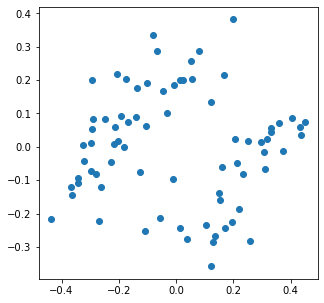

In [53]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.scatter(tX_train[:, 0], tX_train[:, 1])

In [106]:
clf = LogisticRegression(random_state = 0, max_iter = 200).fit(tX_train, y_train)

In [107]:
print(f"Performance on training data {clf.score(tX_train, y_train)}")
print(f"Performance on test data {clf.score(tX_test, y_test)}")

opt_accuracy = clf.score(tX_test, y_test)

Performance on training data 0.8266666666666667
Performance on test data 0.84


# PCA => DP Logistic Regression

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


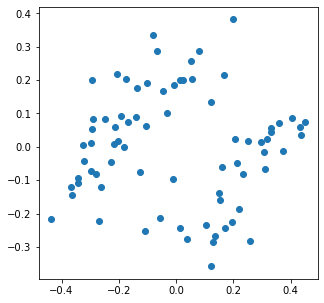

In [59]:
pca = PCA(n_components=5)
tX_train = pca.fit_transform(X_train)
tX_test = pca.transform(X_test)
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.scatter(tX_train[:, 0], tX_train[:, 1])
epsilons = np.logspace(-3, 1, 50)
curves = []
for i in range(100):
    print(i)
    accuracy = []
    for epsilon in epsilons:
        dp_clf = dpm.LogisticRegression(epsilon=epsilon, max_iter = 200).fit(tX_train, y_train, )
        accuracy.append(dp_clf.score(tX_test, y_test))

    curves += [accuracy]


In [60]:
mean_score1 = np.mean(np.array(curves), axis = 0)

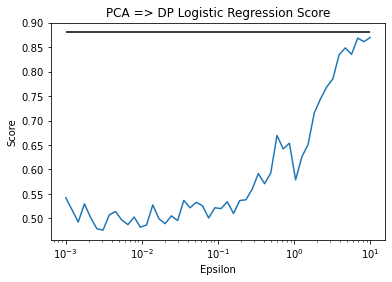

In [61]:
ax = plt.subplot(111)
ax.plot(epsilons, mean_score1)
ax.set_title("PCA => DP Logistic Regression Score")
ax.set_xlabel("Epsilon")
ax.set_ylabel("Score")
ax.set_xscale('log')
ax.hlines(opt_accuracy, epsilons[0],epsilons[-1] , color = "black")

# DP PCA => Logistic Regression

In [101]:
new_epsilons = np.logspace(-3, 1, 50)
curves = []
# for i in range(100):
accuracy = []
print(i)
for epsilon in [0.1]: #new_epsilons:
    # print("epsilon",epsilon)
    dp_pca = dpm.PCA(n_components=5, epsilon = epsilon)
    tX_train = dp_pca.fit_transform(X_train)
    # print(tX_train)
    tX_test = dp_pca.transform(X_test)
    dp_clf2 = LogisticRegression(max_iter = 200).fit(tX_train, y_train, )
    accuracy.append(dp_clf2.score(tX_test, y_test))

curves += [accuracy]


26


In [103]:
new_epsilons = np.logspace(-3, 1, 50)
curves = []
# for i in range(100):
accuracy = []
print(i)
for n_components in range(1, 46): #new_epsilons:
    # print("epsilon",epsilon)
    dp_pca = dpm.PCA(n_components=n_components, epsilon = epsilon)
    tX_train = dp_pca.fit_transform(X_train)
    # print(tX_train)
    tX_test = dp_pca.transform(X_test)
    dp_clf2 = LogisticRegression(max_iter = 200).fit(tX_train, y_train, )
    accuracy.append(dp_clf2.score(tX_test, y_test))

curves += [accuracy]

26


In [104]:
curves

[[0.76,
  0.76,
  0.76,
  0.76,
  0.76,
  0.76,
  0.76,
  0.76,
  0.76,
  0.76,
  0.76,
  0.76,
  0.76,
  0.76,
  0.76,
  0.76,
  0.76,
  0.76,
  0.8,
  0.76,
  0.76,
  0.76,
  0.76,
  0.88,
  0.76,
  0.76,
  0.88,
  0.8,
  0.8,
  0.76,
  0.84,
  0.8,
  0.8,
  0.92,
  0.8,
  0.84,
  0.8,
  0.8,
  0.84,
  0.84,
  0.88,
  0.84,
  0.88,
  0.84,
  0.88]]

In [66]:
mean_score2 = np.mean(np.array(curves), axis = 0)

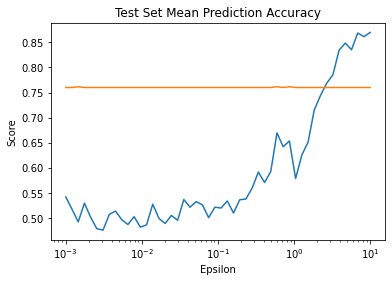

In [67]:
ax = plt.subplot(111)
ax.plot(epsilons, mean_score1, label = "PCA => DP log reg")
ax.plot(new_epsilons, mean_score2, label = "DP PCA => log reg")
ax.set_title("Test Set Mean Prediction Accuracy")
# ax.legend()
ax.set_xlabel("Epsilon")
ax.set_ylabel("Score")
ax.set_xscale('log')
# ax.hlines(opt_accuracy, epsilons[0],epsilons[-1] , color = "black")

In [25]:
curves

[[0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72],
 [0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72],
 [0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72,
  0.72

# MOD-SULQ

In [31]:
V.real

array([[ 1.02341789e-01, -9.09977111e-02, -5.13117489e-02,
        -1.31358169e-01, -2.95292295e-03],
       [ 5.20661558e-02, -2.59561723e-03, -1.77222610e-02,
        -1.69641553e-01,  2.90173246e-02],
       [-1.92311985e-02,  5.47507739e-02, -2.97348565e-02,
        -1.19581323e-01, -2.72840188e-01],
       [-7.59931961e-02, -7.47571214e-02, -6.13281256e-02,
         7.18913937e-02,  1.73676376e-02],
       [-1.84610264e-01,  2.51914693e-02, -4.74687699e-02,
         9.04022102e-02,  3.20695665e-02],
       [ 4.31703425e-02, -9.28550652e-03, -3.74805475e-02,
         9.66211099e-02, -5.16778950e-05],
       [-1.08863398e-01,  5.55572530e-03, -4.85649144e-02,
         1.22445084e-01, -7.34360767e-02],
       [-1.46736831e-01,  1.53735973e-02, -4.80168422e-02,
         1.06423647e-01, -2.06832551e-02],
       [-1.82707145e-02, -4.15779545e-02, -4.55033142e-02,
         8.70874285e-02,  6.85326397e-03],
       [-1.85578770e-01,  2.47326403e-02, -3.84127460e-02,
         1.64763276e-01

In [38]:
epsilons3 = np.logspace(-3, 0, 50)
deltas = [1e-3] #np.logspace(-3, 0, 5)
d = X.shape[1]
n = X.shape[0]
X_mean = np.mean(X, axis=0, keepdims=True)
A =  1/n * (X-X_mean).T @ (X-X_mean)
for i in range(5):
    accuracy = []
    for epsilon in epsilons:
        for delta in deltas:
            beta = (d+1)/(n * epsilon) * np.sqrt(2 * np.log((d**2 + d)/(delta * 2 * np.sqrt(2 * np.pi)))) + 1 / (n * np.sqrt(epsilon))
            noise_matrix = np.zeros((d,d))
            for i in range(d):
                for j in range(i, d):
                    entry = np.random.randn(1) * beta
                    noise_matrix[i,j] = entry
                    noise_matrix[j,i] = entry

            A_mod = A + noise_matrix
            U, V = np.linalg.eig(A_mod)
            V = V[:,np.argsort(np.abs(U))[::-1]]
            V = V[:, :5]
            V  = V.real
            tX_train =  X_train @ V
            tX_test = X_test @ V
            dp_clf = LogisticRegression(max_iter = 200).fit(tX_train, y_train, )
            accuracy.append(dp_clf.score(tX_test, y_test))
    curves += [accuracy]



In [33]:
pca = PCA(n_components=5)
tX_train = pca.fit_transform(X_train)
print(tX_train)

[[-1.83570167e-01  1.79339809e-02  3.08209075e-02 -9.53294437e-03
  -5.61582439e-02]
 [ 4.56855770e-02  1.41789142e-01 -6.96064557e-02 -2.14839159e-01
  -5.97671667e-02]
 [-6.46698108e-02 -2.64671215e-01 -5.72162598e-02 -2.04302868e-02
   1.72830561e-01]
 [ 8.01319646e-02  1.40506652e-01  1.50269771e-01 -6.11968849e-02
  -1.52758300e-02]
 [ 4.33404515e-01  6.96780420e-03  2.13686458e-01  1.01563460e-01
  -4.67750424e-02]
 [-5.70054831e-02 -2.59413840e-01 -1.46893750e-01  1.30141300e-01
  -1.65542637e-01]
 [ 2.69954439e-01  1.68543186e-01 -1.36280397e-01 -2.13092786e-01
  -3.50944956e-02]
 [ 3.14031333e-01  1.21712926e-01  9.64680708e-02  1.12622030e-01
  -2.47181144e-02]
 [ 8.98128840e-02  4.01597916e-01 -1.28147957e-01  1.60430298e-01
   1.68335261e-01]
 [-2.36017566e-02  3.35220127e-01 -6.71994423e-02  6.69049703e-02
  -1.64784381e-01]
 [-1.19861389e-01  3.13600639e-01 -7.68591805e-02  9.71631619e-02
  -1.34047883e-01]
 [-2.74107211e-01 -2.70014711e-02 -1.30221199e-01  7.19824352e-02

In [34]:
U, s, V = np.linalg.svd(X - X_mean)
V = V[:,np.argsort(np.abs(U))[::-1]]
V = V[:, :5]
tX_train =  X_train @ V
print(tX_train)

IndexError: index 61 is out of bounds for axis 1 with size 45

In [39]:
mean_score3 = np.mean(np.array(curves), axis = 0)

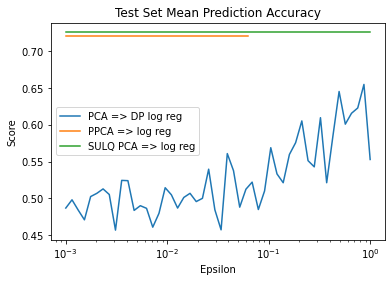

In [40]:
ax = plt.subplot(111)
ax.plot(epsilons, mean_score1, label = "PCA => DP log reg")
ax.plot(new_epsilons, mean_score2, label = "PPCA => log reg")
ax.plot(epsilons3, mean_score3, label = "SULQ PCA => log reg")
ax.set_title("Test Set Mean Prediction Accuracy")
ax.legend()
ax.set_xlabel("Epsilon")
ax.set_ylabel("Score")
ax.set_xscale('log')
# ax.hlines(opt_accuracy, epsilons[0],epsilons[-1] , color = "black")